In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kickstarter-projects/ks-projects-201801.csv
/kaggle/input/kickstarter-projects/ks-projects-201612.csv


Introduction

Kickstarter is an online crowdfunding platform for entrepreneurs to obtain a "kick-start" in capital for their project ideas.

Individual project ideas are uploaded onto the Kickstarter website, where consumers can view information about the project including production plans, budgets and monetary goals. Each project must then reach it's respective monetary goal before it's deadline, which can be anywhere between 1 to 60 days from the project's creation.

Kickstarter adopts an "all-or-nothing" approach to funding, which means that if a project doesn't hit it's goal by the deadline, it receives no funds and is deemed a failed project.

About this project:

Estimating the number of backers needed to have a successful kickstarter campaign
This project aims to deliver some insights into how much support from backers a kickstarter project would need to have a decent chance of success. The end goal is to develop a tool that would allow an entrepreneur to have a reasonable estimate of how different expected numbers of backers can affect his chances of success.

Source
Data obtained from: https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv

Content
This dataset contains about 400,000 rows of data collected on crowdfunding projects hosted on Kickstarter.com.

Columns should be self explanatory.

Acknowledgements
Data is collected from Kickstarter Platform

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

import category_encoders as ce

import joblib

%matplotlib inline

In [5]:
df = pd.read_csv('/kaggle/input/kickstarter-projects/ks-projects-201801.csv', index_col = 'ID')

In [6]:
df.shape

(378661, 14)

In [7]:
df.columns


Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [8]:
df.head(3)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


Part 1: Data cleaning

Cleaning the target variable:

In [9]:
#Check the unique values of the target variable

df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

Kickstarter uses an all-or-nothing funding approach, so complete projects are either successful (completedly funded) or failed (partially funded). I only want to include completed projects with an outcome, therefore cancelled, suspended and undefined project outcomes will be removed.

In [10]:
#Only keep projects that are either failed or successful

df = df[df['state'].isin(['failed','successful'])]

#Checking target variable counts again

df['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [11]:
#Check null values
df.isnull().sum()

name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [12]:
df = df.dropna()

#Check null values again:

df.isnull().sum()

name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

Part 2: EDA and feature engineering
In this section I do some exploratory data analysis on the features, and also create a new feature for subsequent models. I start with some univariate analyses and end off with multivariate analyses.

Target variable (State):

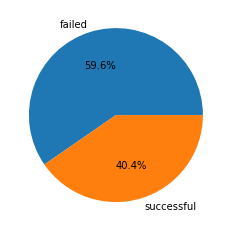

In [13]:
#Show the failure rate of projects

plt.pie(x = df['state'].value_counts(),
        labels = df['state'].value_counts().index,
        autopct='%1.1f%%')

plt.show()

In [14]:
# About 60% of all projects posted to Kickstarter don't reach their goals. We convert the 'failed' and 'successful' states to dummy variables:

#Convert column values to 1's and 0's by creating dummy columns:

df = pd.get_dummies(data = df,
                    columns = ['state'])

#We only have to keep one column:

df = df.drop('state_failed', axis = 1)

<AxesSubplot:ylabel='main_category'>

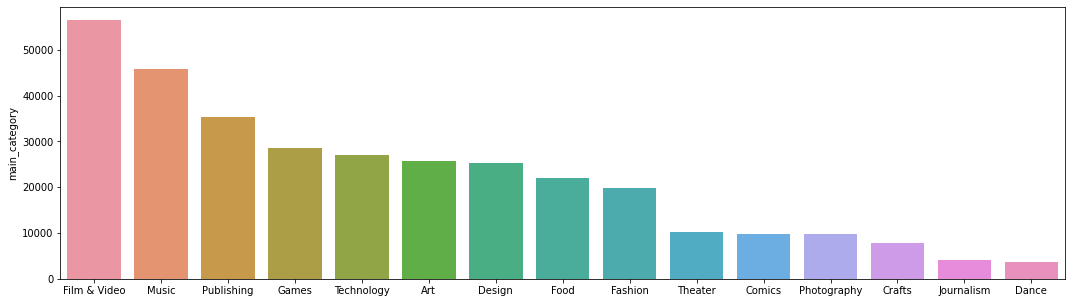

In [15]:
#Check the typical categories for projects

plt.figure(figsize = (18,5))

sns.barplot(x =  df['main_category'].value_counts().index,
            y =  df['main_category'].value_counts())

Seems like project distribution is pretty balanced, a good variety of all kinds of projects except for the last few

Currency that project is paid in:

<AxesSubplot:ylabel='currency'>

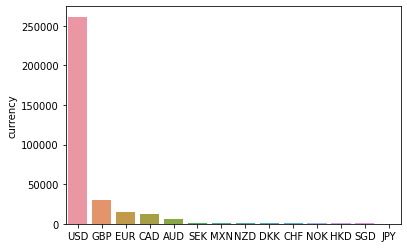

In [16]:
sns.barplot(x = df['currency'].value_counts().index,
            y = df['currency'].value_counts())

In [17]:
df['currency'].value_counts()

USD    261358
GBP     29453
EUR     14357
CAD     12370
AUD      6616
SEK      1509
MXN      1411
NZD      1274
DKK       926
CHF       652
NOK       582
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

Most of the projects are paid in USD, doesn't seem like an important variable. Also it can act as a proxy for the 'Country' variable so we will not include it.

In [18]:
# Deadlines and launch dates of projects:
df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   deadline  331462 non-null  object
 1   launched  331462 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [19]:
# Datatypes are classified as objects. They should be classified as time data instead:

#Converting datatypes:

df = df.astype({'deadline':'datetime64',
                'launched':'datetime64'
               }
              )

#See if conversion is successful:

df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   deadline  331462 non-null  datetime64[ns]
 1   launched  331462 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.6 MB


In [20]:
# Feature engineering a new column:
# Having less time before the deadline might reasonably affect project success. 
# We will create a new column to depict that:

#Create a new column showing time between project launch to deadline

time_to_deadline = df['deadline'] - df['launched']
time_to_deadline[:5]

ID
1000002330   58 days 11:47:32
1000003930   59 days 19:16:03
1000004038   44 days 23:39:10
1000007540   29 days 20:35:49
1000014025   34 days 10:21:33
dtype: timedelta64[ns]

In [21]:
#Only keep the number of days to make it simpler, also as int dtype:

time_to_deadline_days = time_to_deadline.dt.days

df['Days to deadline'] = time_to_deadline_days

df['Days to deadline'][:5]

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000014025    34
Name: Days to deadline, dtype: int64

In [22]:
#Note: Time delta information is stored in pandas in nanoseconds (10^-9).
#Example:

print(time_to_deadline[1:2])
print('\t')
print('Value:', time_to_deadline[1:2].values)
print('\t')
print('Value converted to days:',time_to_deadline[1:2].values /1000 /1000 /1000 #Convert to seconds 
                                                                          /60 #to Minutes
                                                                          /60 #to Hours
                                                                          /24)#to Days

ID
1000003930   59 days 19:16:03
dtype: timedelta64[ns]
	
Value: [5166963000000000]
	
Value converted to days: [59]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


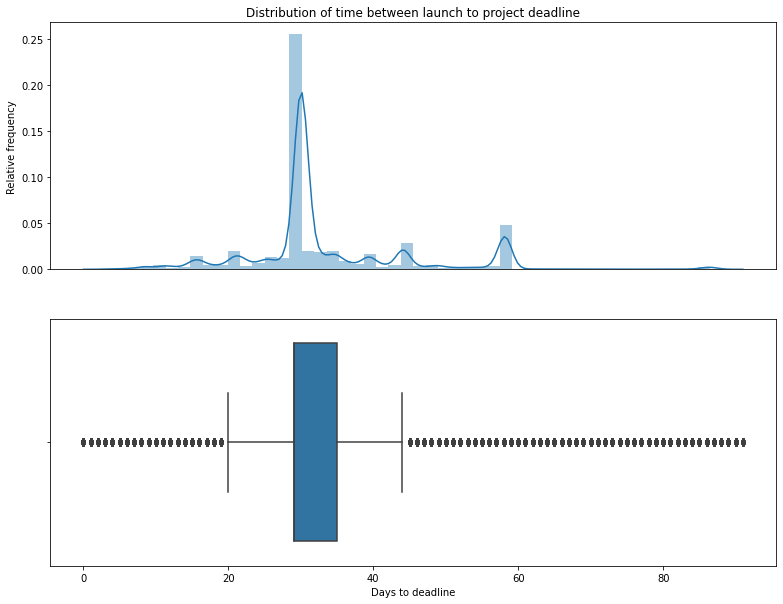

In [23]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))


sns.distplot(df['Days to deadline'],
             ax = ax[0])

sns.boxplot(df['Days to deadline'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')

plt.show()

 ## Definitely high variation in time to deadline, with most projects falling between 20 to 40 days

In [24]:
# Number of project backers:
df['backers'].describe()

count    331462.000000
mean        116.456315
std         965.732911
min           0.000000
25%           2.000000
50%          15.000000
75%          63.000000
max      219382.000000
Name: backers, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


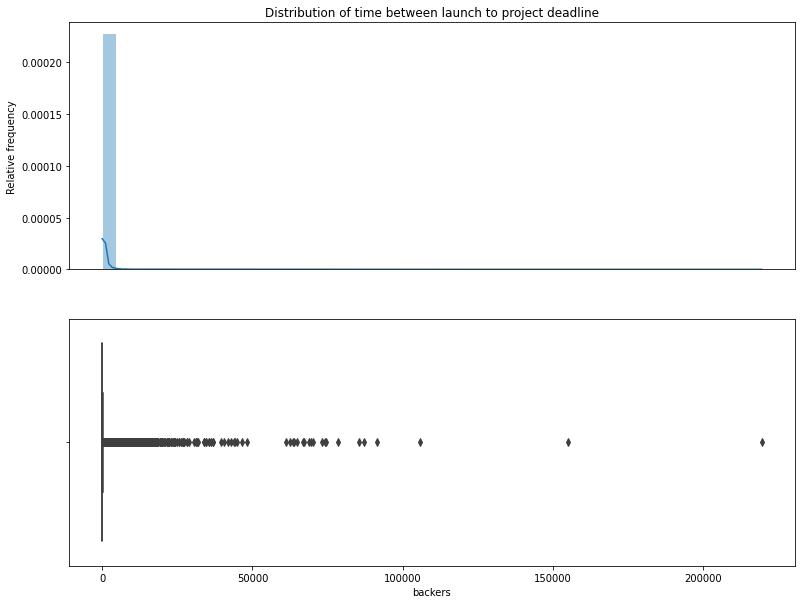

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))

sns.distplot(df['backers'],
             ax = ax[0])

sns.boxplot(df['backers'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')
plt.show()

In [26]:
# Most projects are actually very close to 0 backers - This makes sense since the failure rate is about 60%

# I will also remove rows with extremely high amounts of backers (above 98th percentile), 
# since its reasonable to assume these projects will almost certainly be successful

#Removing top 2 percentiles of data:

df = df[df['backers'] < np.quantile(df['backers'],0.98)]
#Check the new values:

df['backers'].describe()

#Maximum value is now 908 instead of 219,000 

count    324831.000000
mean         57.207332
std         113.427217
min           0.000000
25%           2.000000
50%          14.000000
75%          58.000000
max         908.000000
Name: backers, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


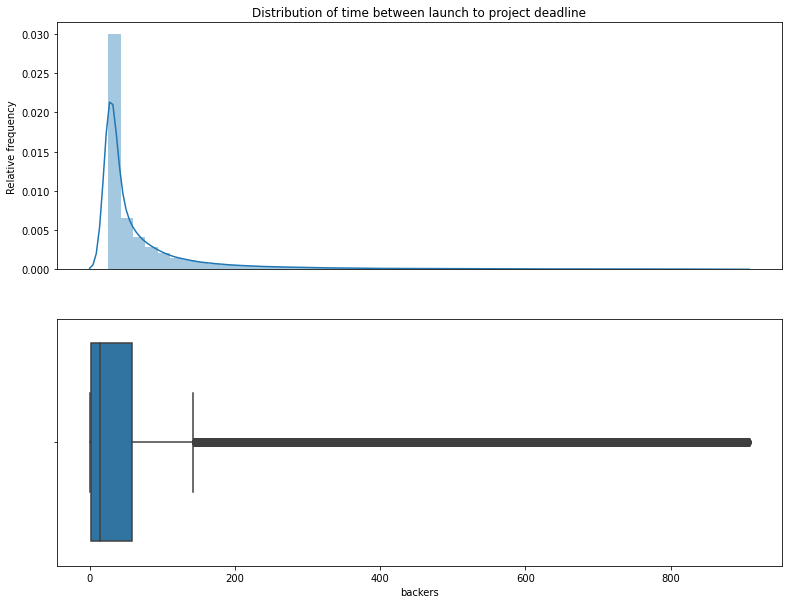

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))


sns.distplot(df['backers'],
             ax = ax[0])

sns.boxplot(df['backers'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')

plt.show()

Distribution still looks very skewed, but at least it's not as extreme as before

In [28]:
# Project goals (measured in real USD value):
df['usd_goal_real'].describe()

count    3.248310e+05
mean     4.110891e+04
std      1.119136e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='usd_goal_real', ylabel='Density'>

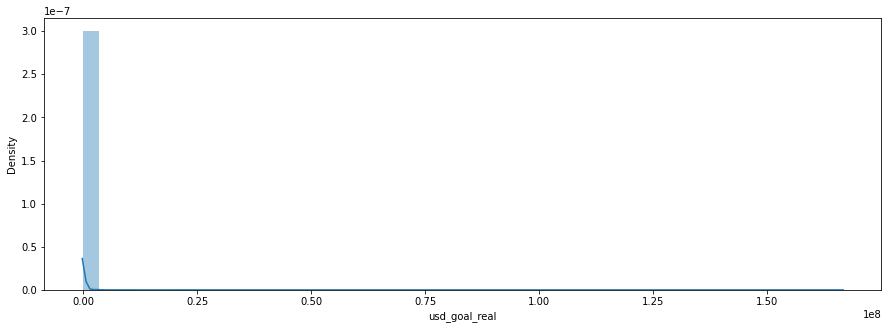

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.distplot(df['usd_goal_real'], 
             ax = ax)